In [1]:
import scanpy as sc
import loompy as lm
import scvelo as scv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [58]:
def clu(adata, key_added, n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, resolution=1, do_scrublet=True, har_key='batch'):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata, random_state=112)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    sc.tl.pca(adata, svd_solver='arpack')
    if do_har:
        sc.external.pp.harmony_integrate(adata, key='batch',max_iter_harmony=max_iter)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, key_added=key_added, resolution=resolution)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [6]:
adata_epi = sc.read_h5ad('adata-epi-total.h5ad')
adata_epi

AnnData object with n_obs × n_vars = 38680 × 39735
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation', 'cnv_leiden', 'cnv_score', 'cnv_status', 'epi-type', 'dpt_pseudotime'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'annotation_colors', 'batch_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendrogram_annotation', 'dendrogram_leiden', 'dendrogram_leiden-1', 'dendrogram_treat', 'diffmap_evals', 'draw_graph', 'epi-s

findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Fon

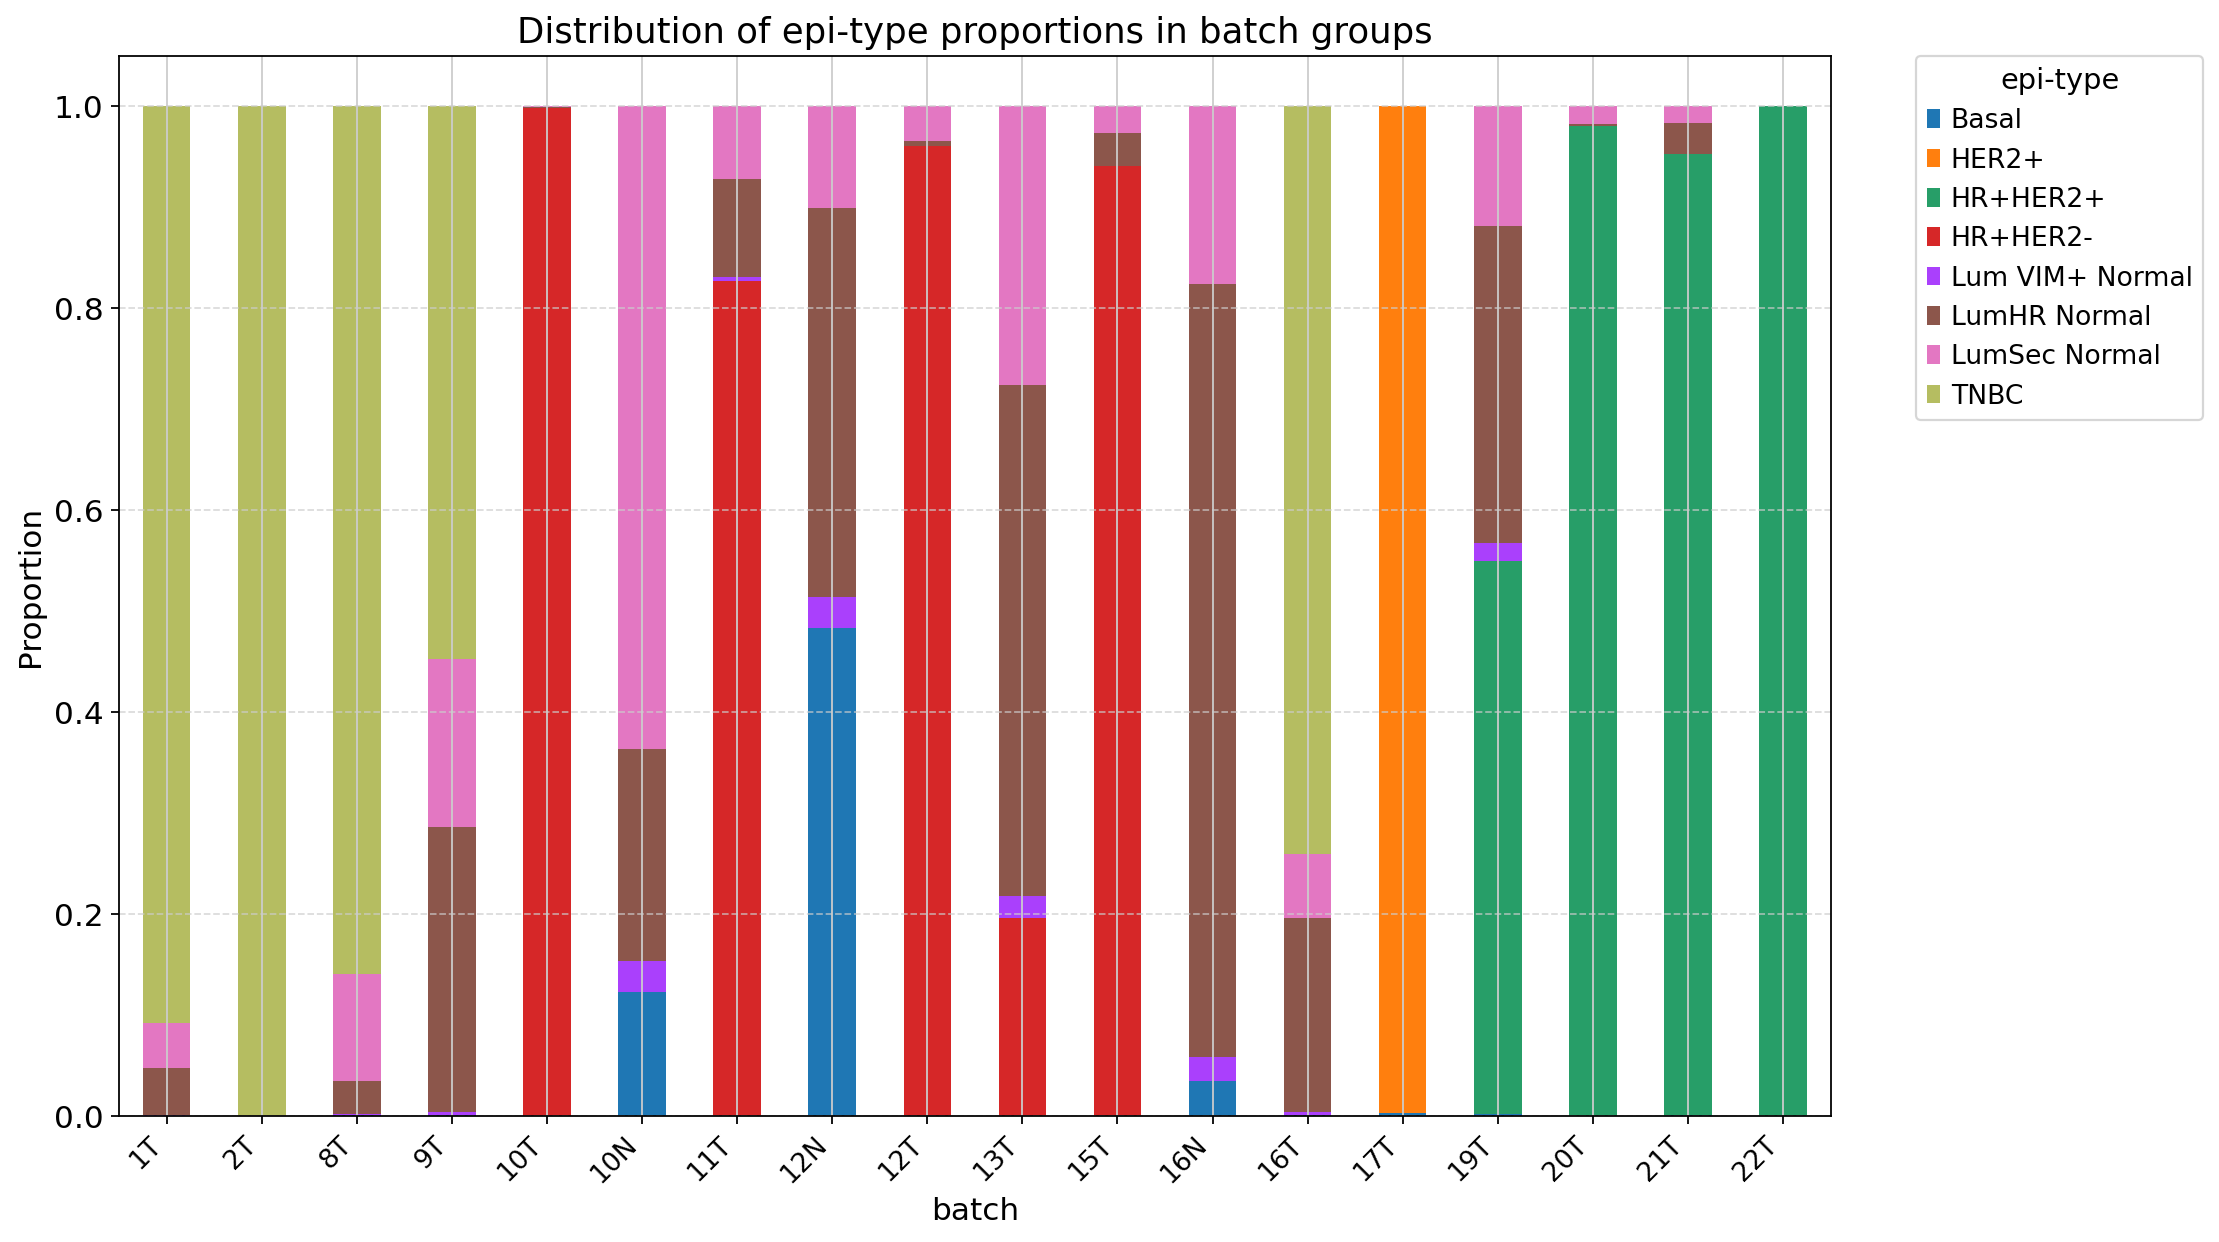

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 确保有分组列（例如 'batch' 或 'leiden'）和类别列（例如 'major_type'）
groupby = 'batch'  # 分组依据
category = 'epi-type'  # 类别依据

# 验证这些列是否存在
if groupby not in adata_epi.obs.columns or category not in adata_epi.obs.columns:
    print(f"Error: 分组列 '{groupby}' 或类别列 '{category}' 不存在!")
else:
    # 创建 contingency table
    contingency_table = pd.crosstab(adata_epi.obs[groupby], adata_epi.obs[category])
    
    # 检查表格是否有多个维度
    if contingency_table.ndim < 2:
        print("警告: contingency table 维度不足，无法用于比例计算。")
    else:
        # 使用 contingency table 计算比例
        proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        
        # 设置中文字体
        plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
        
        # 可视化比例，增加右侧空间以放置图例
        fig, ax = plt.subplots(figsize=(14, 8))
        proportions.plot(kind='bar', stacked=True, ax=ax)
        
        # 设置英文标题和坐标轴标签
        ax.set_title(f'Distribution of {category} proportions in {groupby} groups', fontsize=16)
        ax.set_xlabel(groupby, fontsize=14)
        ax.set_ylabel('Proportion', fontsize=14)  # Y轴标签改为英文
        
        # 调整图例位置到图外右上角
        ax.legend(
            title=category,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            frameon=True,
            fontsize=12,
            title_fontsize=13
        )
        
        # 添加网格线以提高可读性
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # 旋转x轴标签以便更好显示
        plt.xticks(rotation=45, ha='right', fontsize=12)
        
        # 调整布局，为图例留出空间
        plt.subplots_adjust(right=0.8)
        
        plt.tight_layout()
        plt.show()


In [18]:
preDict = ['1T','2T','8T','9T','10N','10T', '11T','12N', '12T', '13T', '15T','16N', '16T',
           '17T', '19T', '20T','21T','22T']

In [19]:
VeloPath='/data/BCY/BCY-velo/'
loomList = [VeloPath + v + '.loom' for v in preDict]
# lm.combine(loomList, output_file="preCombined.loom")
loomList

['/data/BCY/BCY-velo/1T.loom',
 '/data/BCY/BCY-velo/2T.loom',
 '/data/BCY/BCY-velo/8T.loom',
 '/data/BCY/BCY-velo/9T.loom',
 '/data/BCY/BCY-velo/10N.loom',
 '/data/BCY/BCY-velo/10T.loom',
 '/data/BCY/BCY-velo/11T.loom',
 '/data/BCY/BCY-velo/12N.loom',
 '/data/BCY/BCY-velo/12T.loom',
 '/data/BCY/BCY-velo/13T.loom',
 '/data/BCY/BCY-velo/15T.loom',
 '/data/BCY/BCY-velo/16N.loom',
 '/data/BCY/BCY-velo/16T.loom',
 '/data/BCY/BCY-velo/17T.loom',
 '/data/BCY/BCY-velo/19T.loom',
 '/data/BCY/BCY-velo/20T.loom',
 '/data/BCY/BCY-velo/21T.loom',
 '/data/BCY/BCY-velo/22T.loom']

In [20]:
lm.combine_faster(loomList, output_file="neoadjuvant_total.loom")

In [2]:
ldata = sc.read('neoadjuvant_total.loom', cache=True)
ldata.obs_names

Index(['LC_1T:AAACCCATCGAGTGAGx', 'LC_1T:AAACCCATCACTTTGTx',
       'LC_1T:AAATGGAAGTCGCTATx', 'LC_1T:AAAGAACGTCGAGTGAx',
       'LC_1T:AAAGTCCTCCCTAGGGx', 'LC_1T:AAACGAACATAGAATGx',
       'LC_1T:AAAGGGCCATCGATACx', 'LC_1T:AAAGTCCCACGACTATx',
       'LC_1T:AAAGGTAAGCCTGCCAx', 'LC_1T:AAAGAACAGACGACGTx',
       ...
       'LC_22T:TTTCCTCTCTGGGCCAx', 'LC_22T:TTTGCGCTCACCAGGCx',
       'LC_22T:TTTGTCATCTGGCGACx', 'LC_22T:TTTGCGCAGTGACATAx',
       'LC_22T:TTTGTCATCAGTCAGTx', 'LC_22T:TTTGGTTCAAATCCGTx',
       'LC_22T:TTTGCGCAGAGGTACCx', 'LC_22T:TTTCCTCCAGGATCGAx',
       'LC_22T:TTTCCTCTCGTCGTTCx', 'LC_22T:TTTGCGCCATTTCACTx'],
      dtype='object', name='CellID', length=174957)

In [3]:
lcDict = {
          'LC_1T': '1T',
          'LC_2T': '2T',
          'T8': '8T',
          'LC_9T': '9T',
          'N_Paracancerous': '10N', 
          'T_CA': '10T',
          'LC_11T_breast_carcinoma' : '11T',
          'LC_12N_Peritumoral' : '12N',
          'LC_12T_breast_carcinoma' : '12T',
          'LC_13T_breast_carcinoma' : '13T',
          'LC_15_T': '15T',
          'LC_17_N' : '16N',
          'LC_17_T' : '16T',
          'LC_17T' : '17T',
          'LC_19T' : '19T',
          'LC_20T': '20T',
          'LC_21T': '21T',
          'LC_22T': '22T',
        }
lnames = list(ldata.obs_names)
lname = [s.split(':')[1].split('x')[0]+ '-1-'+ lcDict[s.split(':')[0]] for s in lnames]
ldata.obs_names = lname

In [4]:
ldata_epi = ldata[ldata.obs_names.isin(adata_epi.obs_names)]
ldata_epi = scv.utils.merge(ldata_epi,adata_epi)

NameError: name 'adata_epi' is not defined

In [ ]:
ldata_epi 

AnnData object with n_obs × n_vars = 38680 × 27112
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation', 'cnv_leiden', 'cnv_score', 'cnv_status', 'epi-type', 'dpt_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'annotation_colors', 'batch_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendro

In [48]:
ldata_epi.write_h5ad("ldata_epi.h5ad")

In [7]:
ldata_epi = sc.read("ldata_epi.h5ad")

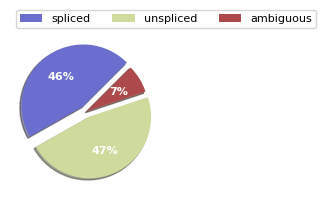

In [8]:
scv.pl.proportions(ldata_epi)

In [9]:
ldata_after = ldata_epi[ldata_epi.obs['treat']=='After']
ldata_after 

View of AnnData object with n_obs × n_vars = 5795 × 27112
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation', 'cnv_leiden', 'cnv_score', 'cnv_status', 'epi-type', 'dpt_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'annotation_colors', 'batch_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 

In [10]:
ldata_after.obs['effect'] = 'better'
ldata_after.obs.loc[ldata_after.obs['batch'].isin(['13T', '19T']),'effect'] = 'better'
ldata_after.obs.loc[ldata_after.obs['batch'].isin(['11T', '12T', '16T']),'effect'] = 'worse'

In [11]:
ldata_after.write_h5ad("ldata_epi_after.h5ad")

In [54]:
scv.tl.velocity(ldata_epi, mode="deterministic")

Normalized count data: X, spliced, unspliced.
computing neighbors


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/tools/velocity.py:326: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  moments(adata)
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:41) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:01:20) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:01:43) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


Ignoring processing doublet cells...
computing PCA
    with n_comps=50
    finished (0:00:15)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:51)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden-epi', the cluster labels (adata.obs, categorical) (0:02:17)


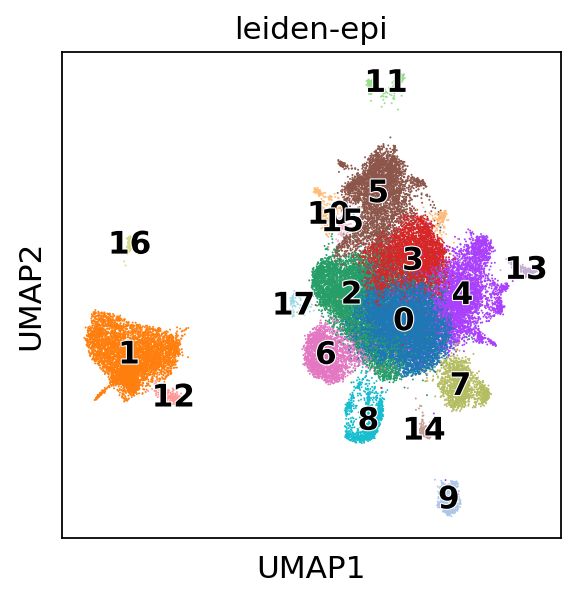

/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-pac

saving figure to file figures/epi-scvelo.svg


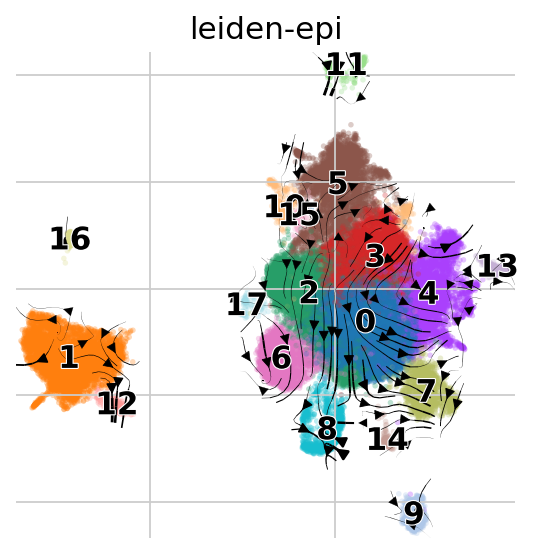

In [98]:
ldata_epi = clu(ldata_epi, do_har=False, do_scrublet=False, key_added='leiden-epi', rep='X_pca_harmony', resolution=0.5, har_key='batch')
scv.pl.velocity_embedding_stream(ldata_epi, basis='umap', color="leiden-epi", save='figures/epi-scvelo.svg')

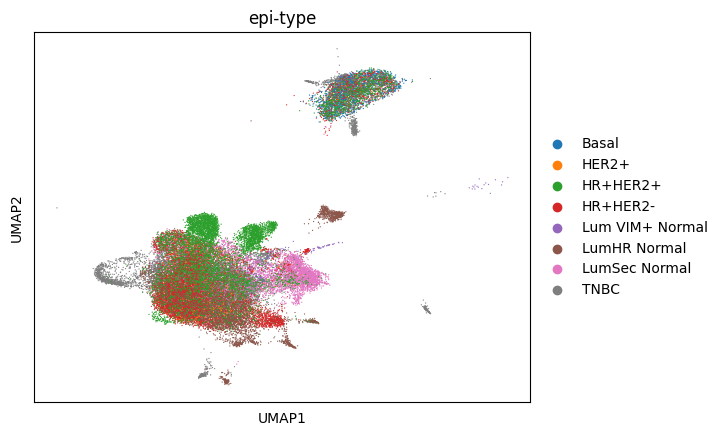

In [ ]:
sc.pl.umap(ldata_epi, color=['epi-type', 'treat'])

In [104]:
scv.tl.rank_velocity_genes(ldata_epi, groupby='treat', min_corr=.3)

ranking velocity genes


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/tools/utils.py:463: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:03:56) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [106]:
# 查看结果
df = pd.DataFrame(ldata_epi.uns['rank_velocity_genes']['names'])
df[:10]


,After,Before,Normal,W/O Treat
0,AGR2,FBXO32,KRT7,RASEF
1,FOXA1,PIK3C2G,AC093001.1,ANKRD30A
2,PTHLH,CDC42EP4,TM4SF1,MUC1
3,CADPS2,DSG3,ALDH1A3,MRPS30-DT
4,AREG,PRAG1,GAPDH,SCUBE2
5,SYTL2,TNFAIP3,RCAN1,RND1
6,GAPDH,LMOD1,SULF1,HSPB8
7,TMEM45A,CDHR1,FOXA1,LAMA3
8,KRT14,GSE1,TMEM45A,ABCC11
9,PIP,EDIL3,DEFB1,FASN


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-pac

saving figure to file figures/epi-velocity-confidence.svg


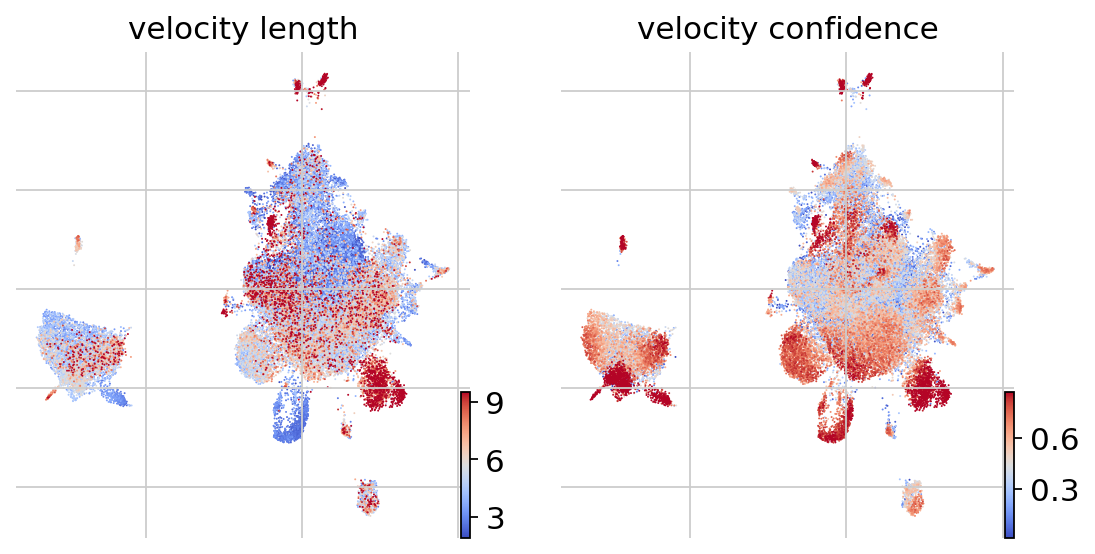

In [107]:
# 基因变化速度与置信度
scv.tl.velocity_confidence(ldata_epi)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(ldata_epi, c=keys, cmap='coolwarm', perc=[5, 95], save= 'figures/epi-velocity-confidence.svg')

running Leiden clustering
    finished: found 7 clusters and added
    'leiden-epi-after', the cluster labels (adata.obs, categorical) (0:00:05)


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-pac

saving figure to file figures/epi-after-scvelo.svg


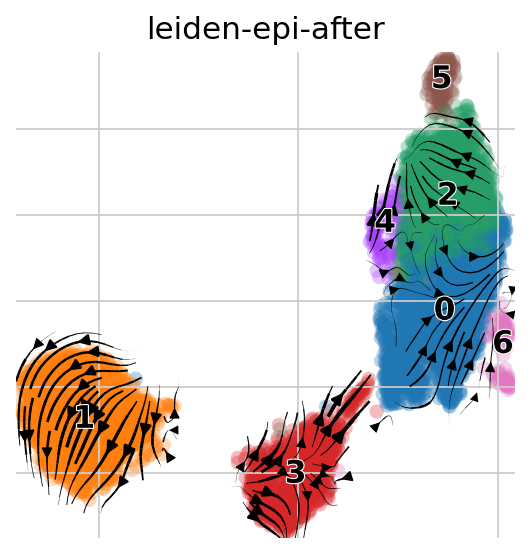

In [91]:
sc.tl.leiden(ldata_after, key_added="leiden-epi-after", resolution=0.5)
scv.pl.velocity_embedding_stream(ldata_after, basis='umap', color="leiden-epi-after", save='figures/epi-after-scvelo.svg')

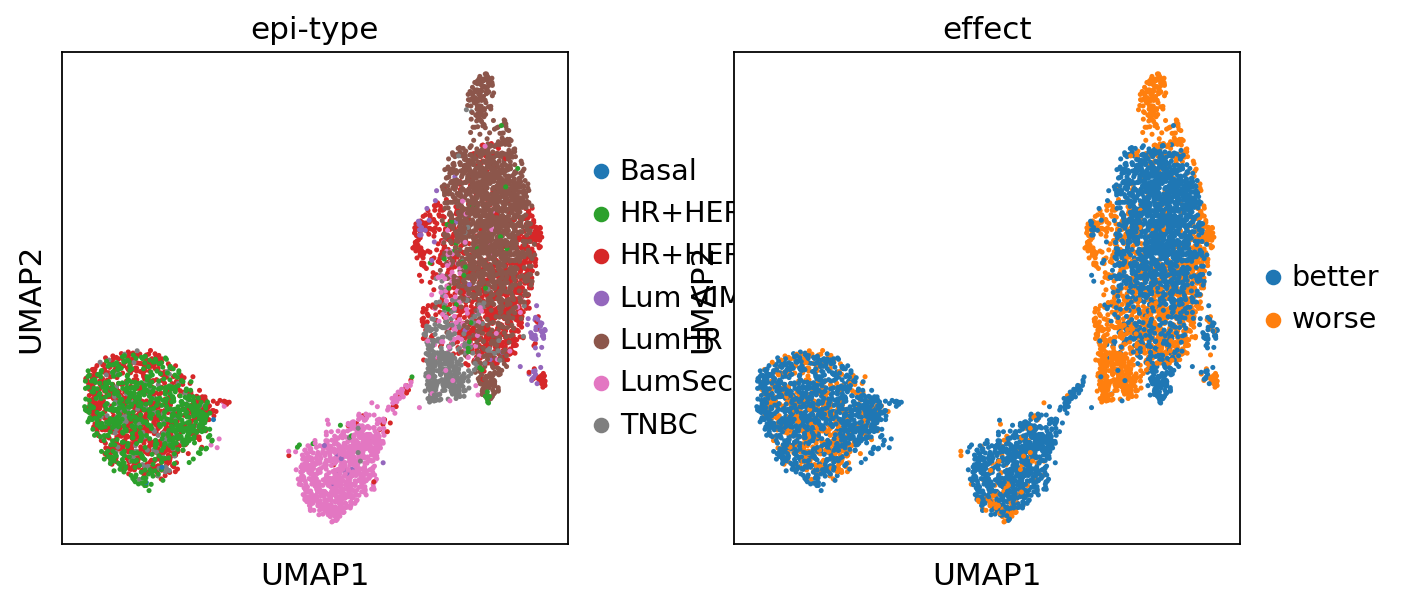

In [85]:
sc.pl.umap(ldata_after, color=['epi-type', 'effect'])

In [100]:
scv.tl.rank_velocity_genes(ldata_after, groupby='effect', min_corr=.3)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [103]:
# 查看结果
df = pd.DataFrame(ldata_after.uns['rank_velocity_genes']['names'])
df[:10]


,better,worse
0,DSC2,GPRC5A
1,ALDH1A3,LRP2
2,PIK3C2G,RDH10
3,KRT19,HSPB8
4,MAL2,SFRP1
5,NTRK2,RND1
6,LIF,CA12
7,STC2,NAV2
8,LIFR,SCUBE2
9,RAP1GDS1,DLG5


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-pac

saving figure to file figures/epi-after-velocity-confidence.svg


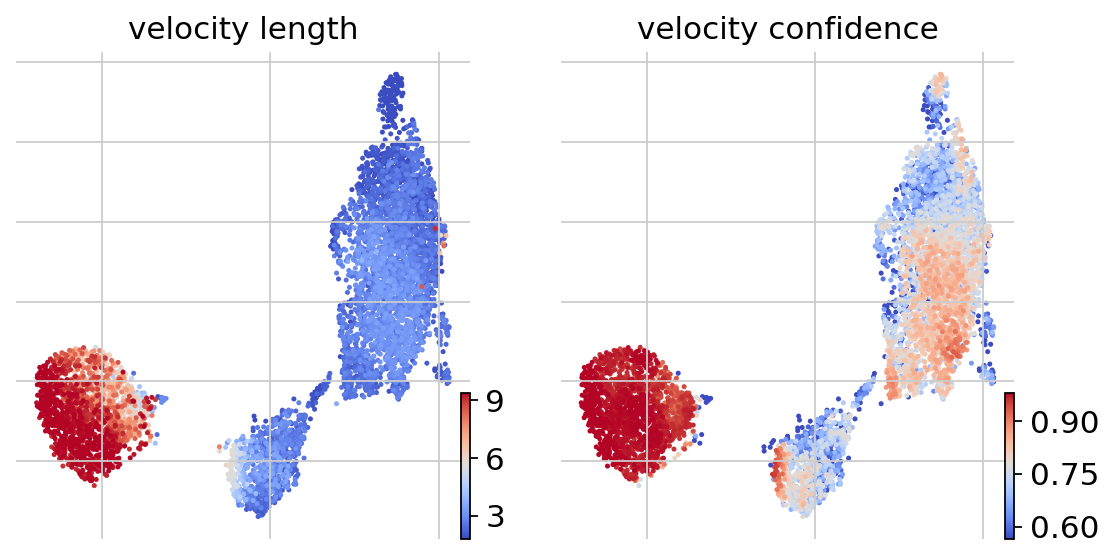

In [108]:
# 基因变化速度与置信度
scv.tl.velocity_confidence(ldata_after)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(ldata_after, c=keys, cmap='coolwarm', perc=[5, 95], save= 'figures/epi-after-velocity-confidence.svg')

computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-pac

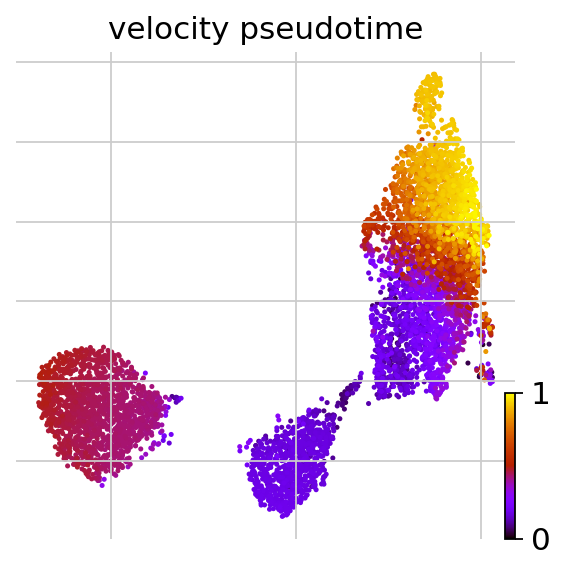

In [ ]:
# 伪时序，颜色越暖越接近分化终点
scv.tl.velocity_pseudotime(ldata_after)
scv.pl.scatter(ldata_after, color='velocity_pseudotime', cmap='gnuplot')

computing latent time using root_cells as prior
    finished (0:00:05) --> added 
    'latent_time', shared time (adata.obs)


/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/hanxue/miniconda3/envs/scseq/lib/python3.10/site-pac

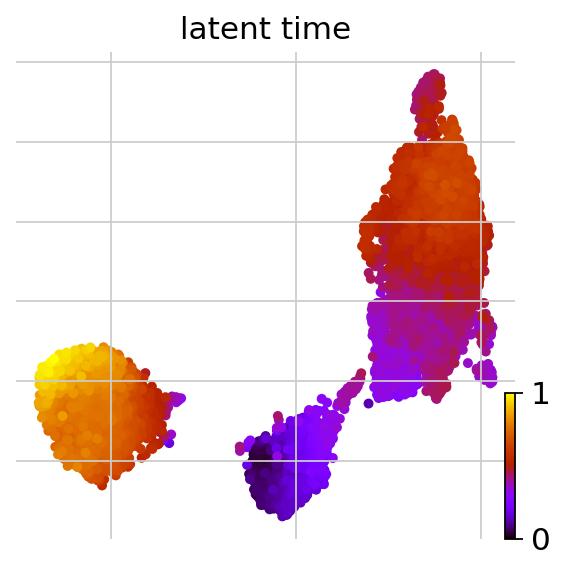

In [87]:
scv.tl.latent_time(ldata_after)
scv.pl.scatter(ldata_after, color='latent_time', color_map='gnuplot', size=80)